# Chapter 9. Additive models, Trees, and Related methods

## 9.1: Generalized additive models

In [209]:
# Import dependent packages
import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import minmax_scale
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import scale
import scipy as sp
from scipy import linalg
plt.style.use('seaborn')
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn import metrics 
from sklearn.linear_model import LogisticRegression
from IPython.display import Image
from sklearn import linear_model
from sklearn.model_selection import KFold
from sklearn.preprocessing import PolynomialFeatures
from pygam import LinearGAM, s, f
from pygam.datasets import wage
from pygam import LogisticGAM
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import export_graphviz
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.tree import DecisionTreeClassifier
import prim
from pyearth import Earth
from sklearn.pipeline import Pipeline


In [174]:
### Function takes two feature transform methods: normalization and MiniMaxScale
def feature_prerpocess(data, form = 'normal'):
    if form == "normal":
        new_data = scale(data)
    elif form == "MinMax":
        new_data = minmax_scale(data)
    return pd.DataFrame(new_data)

In the regression setting, a generalized additive model has the form:

\begin{equation}
E(Y|X_1,X_2,...,X_p) = \alpha + f_1(X_1)+ f_2(X_2)+...+ f_p(X_p)
\end{equation}

where $f_p(X_p)$ is a smooth, non-parametric function. Mainly there are three classes of smooth functions used for GAM:

1. Local regression
2. Smoothing splines
3. Regression splines

#### 1) GAM with local regression at target point $x_{j0}$:

\begin{equation}
E(Y_i|X_{10},X_{20},...,X_{p0}) = \alpha + f_1(X_{10})+ f_2(X_{20})+...+ f_p(X_{p0})
\end{equation}

where locallly weighted regression solves a separate weighted least squares problem at each target point $x_{j0}$:
\begin{equation}
min_{\alpha(x_{j0}), \beta(x_{j0})} = \sum_{i=1}^{N} K_{\lambda}(x_{j0},x_{ji})[y_i-\alpha(x_{j0})- \beta(x_{j0})x_{ji}]^2
\end{equation}

$K_{\lambda}(x_{j0},x_{ji}) = D(\frac{|x_{ji}-x_{j0}|}{\lambda})$

#### 2) GAM with smoothing spline:

In smoothing spline we evaluate the smooth function by minimizing the penalized sum of squares:

\begin{equation}
\sum_{i=1}^{N} (y_i-f(x_i))^2 + \lambda \int f^{//}(x_i))^2 dx	
\end{equation}

where $\lambda \int f^{//}(x_i))^2 dx$ is the penalty term and it imposes smoothness (i.e., penalizes wiggliness).

#### 3) GAM with regression splines:

Regression splines involves fitting separate low-degree polynomials over different regions of $X$. For example, a piecewise cubic polynomial works by fitting a cubic regression mode:

\begin{equation}
y_i = \beta_0 + \beta_1x_i + \beta_2x_i^2 + \beta_3x_i^3 + \epsilon_i
\end{equation}

where the coefficients $\beta_0, \beta_1, \beta_2, and \beta_3$ differ in different parts of the range of $X$. The points where the coefficients change are called $knots$.

A cubic spline with $K$ knots can be modeled as:

\begin{equation}
y_i = \beta_0 + \beta_1b_1(x_i) + \beta_2b_2(x_i) + ... + \beta_{K+3}b_{K+3}(x_i) + \epsilon_i
\end{equation}

for an appropriate choice of basis functions $b_1, b_2, ..., b_{K+3}$


#### 1. GAM regression with PyGAM package

We will use "Seoul Bike" dataset, it can can be downloaded:
* <a href="https://www.kaggle.com/c/seoul-bike-rental-prediction/data">Seoul Bike Rental Prediction
    
The dataset contains weather information (Temperature, Humidity, Windspeed, Visibility, Dewpoint, Solar radiation, Snowfall, Rainfall), the number of bikes rented per hour and date information. The target variable is a bike count required at each hour.

In [175]:
#Download data 
Seoul_bike = pd.read_csv('SeoulBikeData.csv', sep=',', encoding= 'unicode_escape')
Seoul_bike

,Date,Rented Bike Count,Hour,Temperature(°C),Humidity(%),Wind speed (m/s),Visibility (10m),Dew point temperature(°C),Solar Radiation (MJ/m2),Rainfall(mm),Snowfall (cm),Seasons,Holiday,Functioning Day
0,01/12/2017,254,0,-5.2,37,2.2,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes
1,01/12/2017,204,1,-5.5,38,0.8,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes
2,01/12/2017,173,2,-6.0,39,1.0,2000,-17.7,0.0,0.0,0.0,Winter,No Holiday,Yes
3,01/12/2017,107,3,-6.2,40,0.9,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes
4,01/12/2017,78,4,-6.0,36,2.3,2000,-18.6,0.0,0.0,0.0,Winter,No Holiday,Yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8755,30/11/2018,1003,19,4.2,34,2.6,1894,-10.3,0.0,0.0,0.0,Autumn,No Holiday,Yes
8756,30/11/2018,764,20,3.4,37,2.3,2000,-9.9,0.0,0.0,0.0,Autumn,No Holiday,Yes
8757,30/11/2018,694,21,2.6,39,0.3,1968,-9.9,0.0,0.0,0.0,Autumn,No Holiday,Yes
8758,30/11/2018,712,22,2.1,41,1.0,1859,-9.8,0.0,0.0,0.0,Autumn,No Holiday,Yes


For simplicity purposes, we keep only 3 features. 

In [176]:
X_matrix = Seoul_bike.iloc[:100, 3:6]
y_var = Seoul_bike.iloc[:100, 1:2]

# Split dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_matrix, y_var, test_size=0.30)

In [177]:
## model
gam_model = LinearGAM(s(0) + s(1) + s(2))
gam_model.gridsearch(np.asarray(X_train), np.asarray(y_train))
gam_model.summary()

100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                     16.1418
Link Function:                     IdentityLink Log Likelihood:                                  -735.1639
Number of Samples:                           70 AIC:                                             1504.6113
                                                AICc:                                            1516.6048
                                                GCV:                                            24365.3556
                                                Scale:                                          14521.3572
                                                Pseudo R-Squared:                                    0.713
Feature Function                  Lam

In modeling GAM we can decompose and inspect the contribution of each feature to the overall prediction.
This can be done using partial dependence functions.

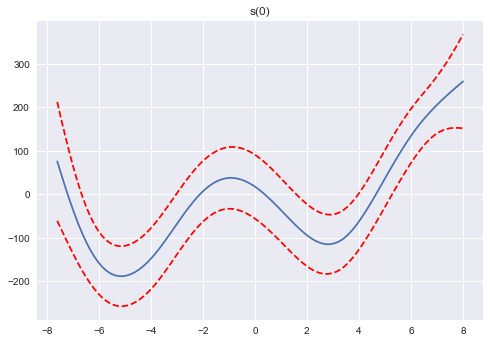

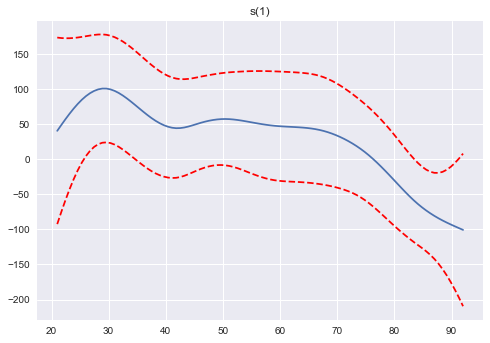

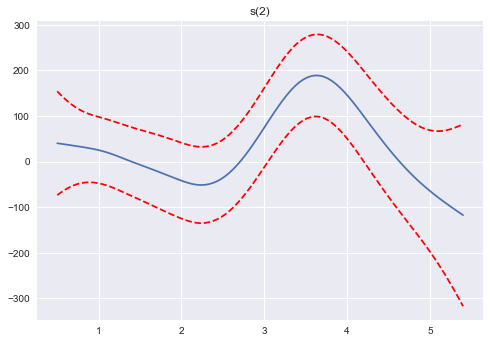

In [178]:
for i, term in enumerate(gam_model.terms):
    if term.isintercept:
        continue
    XX = gam_model.generate_X_grid(term=i)
    pdep, confi = gam_model.partial_dependence(term=i, X=XX, width=0.95)
    plt.figure()
    plt.plot(XX[:, term.feature], pdep)
    plt.plot(XX[:, term.feature], confi, c='r', ls='--')
    plt.title(repr(term))
    plt.show()

#### 2.. GAM classififcation with PyGAM package

We will use "Audit" dataset, it can be downloaded:
* <a href="https://archive.ics.uci.edu/ml/datasets/Audit+Data#">Audit Dataset
    
The dataset contains 777 different firms that are collected from six distinct sectors. The information about the sectors and the counts of firms are listed respectively as Irrigation (114), Public Health (77), Buildings and Roads (82), Forest (70), Corporate (47), Animal Husbandry (95), Communication (1), Electrical (4), Land (5), Science and Technology (3), Tourism (1), Fisheries (41), Industries (37), Agriculture (200). Many risk factors are examined from various areas like past records of audit office, audit-paras, environmental conditions reports, firm reputation summary, on-going issues report, profit-value records, loss-value records, follow-up reports etc. Thus we build a classification model that can predict the fraudulent firm on the basis the present and historical risk factors.

In [179]:
#Download data 
Audit = pd.read_csv('audit_risk.csv', sep=',', encoding= 'unicode_escape')
Audit.describe()

,Sector_score,PARA_A,Score_A,Risk_A,PARA_B,Score_B,Risk_B,TOTAL,numbers,Score_B.1,...,RiSk_E,History,Prob,Risk_F,Score,Inherent_Risk,CONTROL_RISK,Detection_Risk,Audit_Risk,Risk
count,776.000000,776.000000,776.000000,776.000000,776.000000,776.000000,776.000000,776.000000,776.000000,776.000000,...,776.000000,776.000000,776.000000,776.000000,776.000000,776.000000,776.000000,776.0,776.000000,776.000000
mean,20.184536,2.450194,0.351289,1.351029,10.799988,0.313144,6.334008,13.218481,5.067655,0.223711,...,0.519072,0.104381,0.216753,0.053608,2.702577,17.680612,0.572680,0.5,7.168158,0.393041
std,24.319017,5.678870,0.174055,3.440447,50.083624,0.169804,30.072845,51.312829,0.264449,0.080352,...,0.290312,0.531031,0.067987,0.305835,0.858923,54.740244,0.444581,0.0,38.667494,0.488741
min,1.850000,0.000000,0.200000,0.000000,0.000000,0.200000,0.000000,0.000000,5.000000,0.200000,...,0.400000,0.000000,0.200000,0.000000,2.000000,1.400000,0.400000,0.5,0.280000,0.000000
25%,2.370000,0.210000,0.200000,0.042000,0.000000,0.200000,0.000000,0.537500,5.000000,0.200000,...,0.400000,0.000000,0.200000,0.000000,2.000000,1.583500,0.400000,0.5,0.316700,0.000000
50%,3.890000,0.875000,0.200000,0.175000,0.405000,0.200000,0.081000,1.370000,5.000000,0.200000,...,0.400000,0.000000,0.200000,0.000000,2.400000,2.214000,0.400000,0.5,0.555600,0.000000
75%,55.570000,2.480000,0.600000,1.488000,4.160000,0.400000,1.840500,7.707500,5.000000,0.200000,...,0.400000,0.000000,0.200000,0.000000,3.250000,10.663500,0.400000,0.5,3.249900,1.000000
max,59.850000,85.000000,0.600000,51.000000,1264.630000,0.600000,758.778000,1268.910000,9.000000,0.600000,...,2.400000,9.000000,0.600000,5.400000,5.200000,801.262000,5.800000,0.5,961.514400,1.000000


Again for simplicity purposes, we keep only 3 features. 

In [180]:
X_matrix = Audit.iloc[:100, 3:6]
y_var = Audit.iloc[:100, -1] 

# Split dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_matrix, y_var, test_size=0.30)

In [181]:
X_matrix

,Score_A,Risk_A,PARA_B
0,0.6,2.508,2.50
1,0.2,0.000,4.83
2,0.2,0.102,0.23
3,0.2,0.000,10.80
4,0.2,0.000,0.08
...,...,...,...
95,0.2,0.000,0.08
96,0.4,0.476,12.88
97,0.2,0.000,2.72
98,0.2,0.000,1.66


In [182]:
## model
gam_model = LogisticGAM(s(0) + s(1) + s(2))
gam_model.gridsearch(np.asarray(X_train), np.asarray(y_train))
gam_model.summary()

  9% (1 of 11) |##                       | Elapsed Time: 0:00:00 ETA:   0:00:02

did not converge


 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00

did not converge


100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


LogisticGAM                                                                                               
=============================================== ==========================================================
Distribution:                      BinomialDist Effective DoF:                                      4.0372
Link Function:                        LogitLink Log Likelihood:                                   -18.1585
Number of Samples:                           70 AIC:                                               44.3914
                                                AICc:                                              45.3423
                                                UBRE:                                               2.6803
                                                Scale:                                                 1.0
                                                Pseudo R-Squared:                                   0.6201
Feature Function                  Lam

In [183]:
# Accuracy of the training model
print("Accuracy: {} ".format(gam_model.accuracy(X_train, y_train)))

Accuracy: 0.8571428571428571 


## 9.2: Tree-based methods

### 9.2.2: Regression trees

Consider a splitting variable $j$ and split point $s$, and define the pair of half-planes:

\begin{equation}
R_1(j,s) = \{X|X_j<s\} and R_2(j,s) = \{X|X_j>s\}
\end{equation}

Then we seek the splitting varible $j$ and split point $s$ that solve:

\begin{equation}
\substack{min\\j,s} [\substack{min\\c_1} \sum_{x_i \in R_1(j,s)}^{}(y_i-c_1)^2 + \substack{min\\c_2} \sum_{x_i \in R_2(j,s)}^{}(y_i-c_2)^2 ] 
\end{equation}

For any choice $j$ and $s$, the inner minimization is solved by:

\begin{equation}
\hat{c_1} = ave(\{y_i|\in R_1(j,s)),  \hat{c_2} = ave(\{y_i|\in R_2(j,s))
\end{equation}


The preferred strategy is to grow a large $T_0$, stopping the splitting process only when some minimum node size is reached. Then this large tree is pruned using **cost-complexity pruning**. We define the cost complexity criterion:

\begin{equation}
C_\alpha(T) = \sum_{m=1}^{|T|}N_mQ_m(T)+\alpha|T|
\end{equation}

where 
\begin{equation}
N_m = \# \{x_i \in R_m\},
\end{equation}

\begin{equation}
\hat{c_m} = \frac{1}{N_m} \sum_{x_i \in R_m}^{}y_i,
\end{equation}

\begin{equation}
Q_m(T)= \frac{1}{N_m} \sum_{x_i \in R_m}^{}(y_i-\hat{c_m})^2
\end{equation}

The idea is to find, for each $\alpha$, the subtree $T_\alpha \in T_0$ to minimize $C_\alpha(T)$. The tuning parameter $\alpha>0$ governs the tradeoff between tree size and its goodness of fit to the data.


In [184]:
X_matrix_bike = Seoul_bike.iloc[:500, 3:6]
y_var_bike = Seoul_bike.iloc[:500, 1:2]

# Split dataset into training and test sets
X_train_bike, X_test_bike, y_train_bike, y_test_bike = train_test_split(X_matrix_bike, y_var_bike, test_size=0.30)

In [185]:
n_features = X_train_bike.shape[1]
n_samples = X_train_bike.shape[0]

grid = GridSearchCV(DecisionTreeRegressor(random_state=1), cv=10, n_jobs=-1, verbose=5,
                    param_grid ={
                    'max_depth': [2,3,4,5,6,7],
                    'min_samples_split': [2,0.3,0.5, n_samples//2, n_samples//3, n_samples//5],
                    'min_samples_leaf':[1, 0.3,0.5, n_samples//2, n_samples//3, n_samples//5]},
                    )

grid.fit(X_train_bike, y_train_bike)

print('Train R^2 Score : %.3f'%grid.best_estimator_.score(X_train_bike, y_train_bike))
print('Test R^2 Score : %.3f'%grid.best_estimator_.score(X_test_bike, y_test_bike))
print('Best R^2 Score Through Grid Search : %.3f'%grid.best_score_)
print('Best Parameters : ',grid.best_params_)

Fitting 10 folds for each of 216 candidates, totalling 2160 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 1552 tasks      | elapsed:    3.0s


Train R^2 Score : 0.312
Test R^2 Score : 0.228
Best R^2 Score Through Grid Search : 0.181
Best Parameters :  {'max_depth': 3, 'min_samples_leaf': 1, 'min_samples_split': 2}


[Parallel(n_jobs=-1)]: Done 2160 out of 2160 | elapsed:    4.4s finished


In [186]:
print("Feature Importance : %s"%str(grid.best_estimator_.feature_importances_))

Feature Importance : [0.611871 0.352340 0.035789]


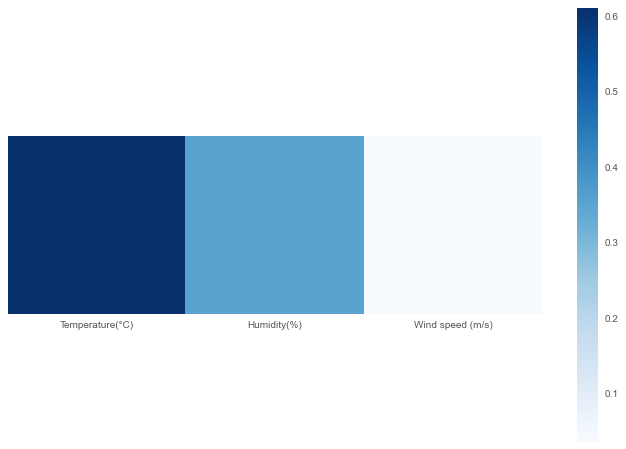

In [187]:
with plt.style.context(('seaborn', 'ggplot')):
    plt.figure(figsize=(12,8))
    plt.imshow(grid.best_estimator_.feature_importances_.reshape(1,-1), cmap=plt.cm.Blues, interpolation='nearest')
    plt.xticks(range(3), list(X_train_bike.columns))
    plt.yticks([])
    plt.grid(None)
    plt.colorbar();

### 9.2.3: Classification trees

In classification case, different measures $Q_m(T)$ of node impurity include the following:

1. Misclassififcation error:
\begin{equation}
\frac{1}{N_m} \sum_{i \in R_m}^{} I(y_i=k(m))
\end{equation}

2. Gini index:
\begin{equation}
\sum_{k=1}^{K} \hat{p_{mk}}(1-\hat{p_{mk}})
\end{equation}

2. Cross-entropy:
\begin{equation}
-\sum_{k=1}^{K} \hat{p_{mk}} log(\hat{p_{mk}})
\end{equation}

In [188]:
X_matrix_audit = Audit.iloc[:, 3:6]
y_var_audit = Audit.iloc[:, -1] 

# Split dataset into training and test sets
X_train_audit, X_test_audit, y_train_audit, y_test_audit = train_test_split(X_matrix_audit, y_var_audit, test_size=0.30)

In [189]:
n_features = X_train_audit.shape[1]
n_samples = X_train_audit.shape[0]

grid = GridSearchCV(DecisionTreeRegressor(random_state=1), cv=10, n_jobs=-1, verbose=5,
                    param_grid ={
                    'max_depth': [4,5,6,7],
                    'min_samples_split': [2,0.3,0.5, n_samples//2, n_samples//3, n_samples//5],
                    'min_samples_leaf':[1, 0.3,0.5, n_samples//2, n_samples//3, n_samples//5]},
                    )

grid.fit(X_train_audit, y_train_audit)
print('Train Accuracy : %.3f'%grid.best_estimator_.score(X_train_audit, y_train_audit))
print('Test Accuracy : %.3f'%grid.best_estimator_.score(X_test_audit, y_test_audit))
print('Best Score Through Grid Search : %.3f'%grid.best_score_)
print('Best Parameters : ',grid.best_params_)

Fitting 10 folds for each of 144 candidates, totalling 1440 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    0.2s


Train Accuracy : 0.624
Test Accuracy : 0.599
Best Score Through Grid Search : 0.546
Best Parameters :  {'max_depth': 4, 'min_samples_leaf': 1, 'min_samples_split': 2}


[Parallel(n_jobs=-1)]: Done 1348 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 1440 out of 1440 | elapsed:    1.6s finished


In [190]:
print("Feature Importance : %s"%str(grid.best_estimator_.feature_importances_))

Feature Importance : [0.000000 0.219669 0.780331]


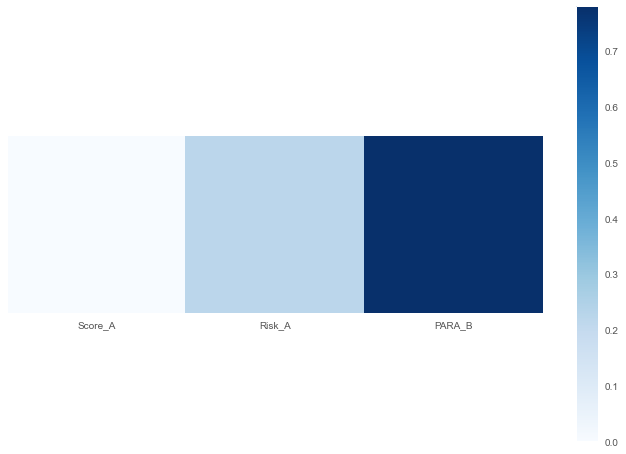

In [191]:
with plt.style.context(('seaborn', 'ggplot')):
    plt.figure(figsize=(12,8))
    plt.imshow(grid.best_estimator_.feature_importances_.reshape(1,-1), cmap=plt.cm.Blues, interpolation='nearest')
    plt.xticks(range(3), list(X_train_audit.columns))
    plt.yticks([])
    plt.grid(None)
    plt.colorbar();

## 9.2: PRIM: Bump hunting

The patient rule induction method (PRIM) also finds boxes in the feature space, but seeks boxes in which the response average is high.  

**Algorithm:**  
1. Start with all of the training data, and a maximal box containing all of the data.  
2. Consider shrinking the box by compressing one face, so as to peel off the proportion $\alpha$ of observations having the highest values of a predictor $X_j$ or the lowest.
3. Repeat step 2 until some minimal number of observations remain in the box.
4. Expand the boz along any face, as long as the resulting box mean increases.
5. Steps 1-4 give a sequence of boxes, with different numbers of observations in each box. Use cross-validation to choose a member of the sequence. Call the box $Box_1$.
6. Remove the data in box $B_1$ from the dataset and repeat steps 2-5 to obtainf a second boz, and continue to get as many boxes as desired.

Python implementation of PRIM using **prim** package.

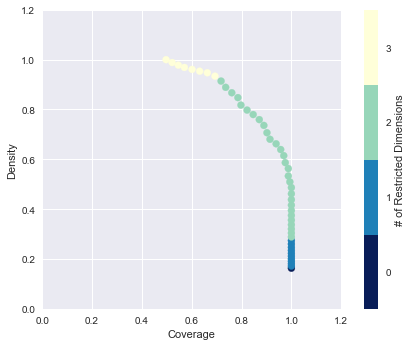

In [192]:
data = pd.DataFrame(np.random.rand(1000, 3), columns=["x1", "x2", "x3"])
y = data["x1"]*(0.8*data["x2"]) + 0.2*data["x3"]
model = prim.Prim(data, y, threshold=0.5, threshold_type=">")
box = model.find_box()
box.show_tradeoff()
plt.show()

In [193]:
print(box)

Box 1 [Peeling Trajectory 47]
    Stats
        Coverage: 0.496933
        Density:  1.000000
        Mass:     0.081000
        Res Dim:  3.000000
        Mean:     1.000000
    Limits
                 min       max     qp values
        x1  0.748767  0.999814  3.186791e-33
        x2  0.621717  0.998101  1.488267e-31
        x3  0.121956  0.997692  3.183055e-02


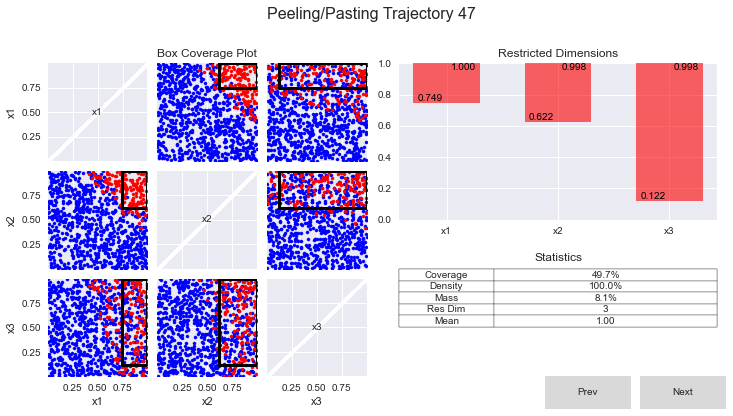

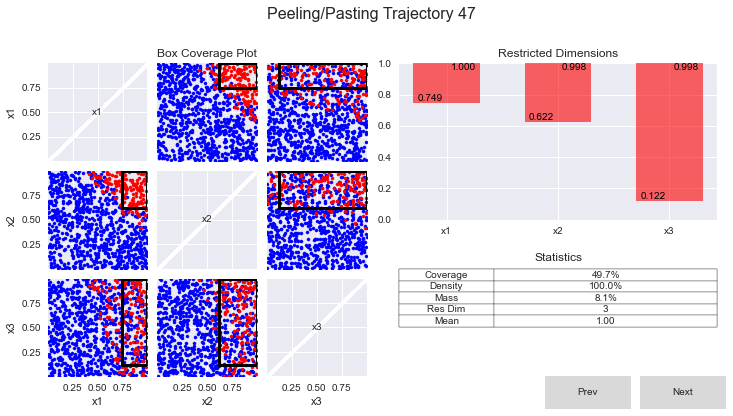

In [194]:
box.show_details()

## 9.3: MARS: Multivariate adaptive regression splines

MARS uses expansions in piecewise linear functions of the form $(x-t)_+$ and $(t-x)_+$. The "+" means positive part, so

\begin{equation}
(x-t)_+ = 
  \begin{cases}
   (x-t)    & \quad \text{if } x>t\\
    0  & \quad \text{otherwise}
  \end{cases}
\end{equation}

\begin{equation}
(t-x)_+ = 
  \begin{cases}
   (t-x)    & \quad \text{if } x<t\\
    0  & \quad \text{otherwise}
  \end{cases}
\end{equation}


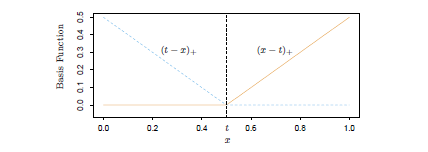

In [195]:
Image(filename='MARS.png', width=800,  height =100) 

Each function is piecewise linear, with a $knot$ at the value $t$. We call the two functions a **a reflected pair**. The idea is to form reflected pairs for each input $X_j$ with knots at each observed value $x_{ij}$ of that input. Therefore, the collection of basis functions is

\begin{equation}
C = \{(X_j-t)_+, (t-X_j)_+\}, t\in {x_{1j},x_{2j}, ..., x_{nj}}, j=1,2,...,p. 
\end{equation}

The model-building strategy is like a forward stepwise linear regression, but instead of using the original inputs, we are allowed to use functions from the set $C$ and their products. Thus the model has the form:

\begin{equation}
f(X) = \beta_0 + \sum_{m=1}^{M}\beta_m h_m(X)
\end{equation}

where $h_m(X)$ is a function in $C$, or a product of two or more such functions.

#### 1) Python implementation of MARS for a regression problem using "py-earth" package.

Beginning forward pass
-----------------------------------------------------------------------
iter  parent  var  knot  mse           terms  gcv        rsq    grsq   
-----------------------------------------------------------------------
0     -       -    -     45063.931429  1      46379.598  0.000  0.000  
1     0       1    14    35862.184361  3      42901.539  0.204  0.075  
2     0       0    -1    33014.119393  4      42770.622  0.267  0.078  
3     3       0    63    28805.023707  6      44214.775  0.361  0.047  
4     3       0    34    20307.244007  8      37517.389  0.549  0.191  
5     3       1    14    16506.894018  10     37407.229  0.634  0.193  
6     2       0    36    13665.315467  12     38879.399  0.697  0.162  
7     0       0    34    10970.547417  14     40349.546  0.757  0.130  
8     1       2    -1    10340.813883  15     43832.170  0.771  0.055  
9     0       0    11    10100.431681  17     58849.126  0.776  -0.269  
10    15      1    -1    9615.309140  18

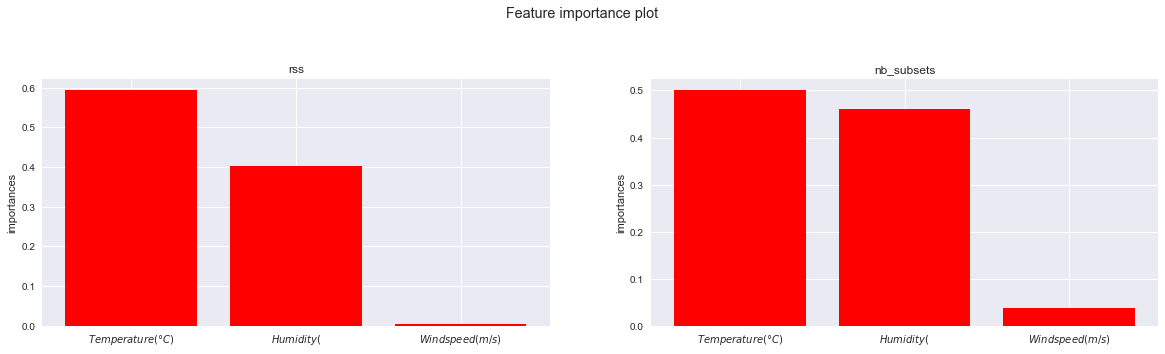

In [203]:
X_matrix = Seoul_bike.iloc[:100, 3:6]
y_var = Seoul_bike.iloc[:100, 1:2]

# Split dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_matrix, y_var, test_size=0.30)

# Fit an Earth model
criteria = ('rss', 'nb_subsets')
model_MARS = Earth(max_degree=2,
              max_terms=20,
              minspan_alpha=.5,
              feature_importance_type=criteria,
              verbose=True)
model_MARS.fit(X_train, y_train)
# Print the model
print(model_MARS.trace())
print(model_MARS.summary())
print(model_MARS.summary_feature_importances(sort_by='rss'))

# Plot the feature importances
importances = model_MARS.feature_importances_
idx = 1
n = X_train.shape[1]

fig = plt.figure(figsize=(20, 10))
labels = ['${}$'.format(i) for i in X_train.columns]
for crit in criteria:
    plt.subplot(2, 2, idx)
    plt.bar(np.arange(len(labels)),
            importances[crit],
            align='center',
            color='red')
    plt.xticks(numpy.arange(len(labels)), labels)
    plt.title(crit)
    plt.ylabel('importances')
    idx += 1
fig.suptitle("Feature importance plot", fontsize="x-large")
plt.show()

#### 2) Python implementation of MARS for a classification problem using "py-earth" package. 

In [251]:
X_matrix = Audit.iloc[:100, 3:6]
y_var = Audit.iloc[:100, -1] 

# Split dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_matrix, y_var, test_size=0.30)

# Combine Earth with LogisticRegression in a pipeline to do classification
earth_classifier = Pipeline([('earth', Earth(max_degree=3, penalty=1.5)),
                             ('logistic', LogisticRegression())])

param_grid = {
    'earth__max_degree': [1,2],
    'earth__max_terms': [6,8,10,12]}

search = GridSearchCV(earth_classifier, param_grid, n_jobs=-1, cv=10)
search.fit(X_train, y_train)

print("Best parameter (CV score=%0.3f):" % search.best_score_)
print(search.best_params_)
print("Accuracy:"+ str(1-np.sum(np.absolute(search.predict(X_test)-y_test))/len(y_test)))

Best parameter (CV score=0.886):
{'earth__max_degree': 1, 'earth__max_terms': 6}
Accuracy:0.8
